In [1]:
!pip install torch torchvision matplotlib -q

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

# load MNIST data
train_set = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_set  = datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=512, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


In [3]:
class VGG11(nn.Module):
  # VGG11 CNN architecture
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
      nn.Conv2d(1,64,3,1,1),nn.BatchNorm2d(64),nn.ReLU(),nn.MaxPool2d(2,2),
      nn.Conv2d(64,128,3,1,1),nn.BatchNorm2d(128),nn.ReLU(),nn.MaxPool2d(2,2),
      nn.Conv2d(128,256,3,1,1),nn.BatchNorm2d(256),nn.ReLU(),
      nn.Conv2d(256,256,3,1,1),nn.BatchNorm2d(256),nn.ReLU(),nn.MaxPool2d(2,2),
      nn.Conv2d(256,512,3,1,1),nn.BatchNorm2d(512),nn.ReLU(),
      nn.Conv2d(512,512,3,1,1),nn.BatchNorm2d(512),nn.ReLU(),nn.MaxPool2d(2,2),
      nn.Conv2d(512,512,3,1,1),nn.BatchNorm2d(512),nn.ReLU(),
      nn.Conv2d(512,512,3,1,1),nn.BatchNorm2d(512),nn.ReLU(),nn.MaxPool2d(2,2),
    )
    self.classifier = nn.Sequential(
      nn.Linear(512,4096),nn.ReLU(),nn.Dropout(0.5),
      nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(0.5),
      nn.Linear(4096,10)
    )
  def forward(self,x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    return self.classifier(x)

# ZERO DEFENSE MODEL:
model = VGG11().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
epochs = 3
train_acc = []
test_acc = []
train_loss = []
test_loss = []

for epoch in range(epochs):
  # train
  model.train()
  correct=0
  total=0
  running_loss=0
  for x,y in train_loader:
    x=x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    out = model(x)
    loss = criterion(out,y)
    loss.backward(); optimizer.step()
    running_loss += loss.item()*y.size(0)
    _,preds = out.max(1)
    total+=y.size(0)
    correct+=preds.eq(y).sum().item()
  train_loss.append(running_loss/total)
  train_acc.append(correct/total)

  # test
  model.eval()
  correct=0
  total=0
  running_loss=0
  for x,y in test_loader:
    x = x.to(device)
    y = y.to(device)
    out = model(x)
    loss = criterion(out,y)
    running_loss += loss.item()*y.size(0)
    _,preds = out.max(1)
    total+=y.size(0)
    correct+=preds.eq(y).sum().item()
  test_loss.append(running_loss/total)
  test_acc.append(correct/total)

  print("Epoch " + str(epoch+1) + ":")
  print("Train acc = "+str(train_acc[-1]))
  print("Train loss = "+str(train_loss[-1]))
  print("Test acc = "+str(test_acc[-1]))
  print("Test loss = "+str(test_loss[-1]))



Epoch 1:
Train acc = 0.5802666666666667
Train loss = 1.0873442703723908
Test acc = 0.9499
Test loss = 0.18085015578269958
Epoch 2:
Train acc = 0.9751666666666666
Train loss = 0.08880274767478306
Test acc = 0.9809
Test loss = 0.06018217729926109
Epoch 3:
Train acc = 0.9857166666666667
Train loss = 0.051217029883464174
Test acc = 0.9778
Test loss = 0.08167016608715057


epsilon = 0.1 | accuracy: 0.5877


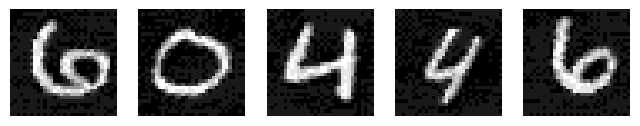

epsilon = 0.2 | accuracy: 0.0861


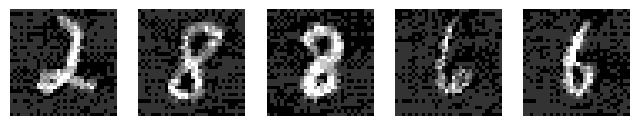

epsilon = 0.5 | accuracy: 0.0769


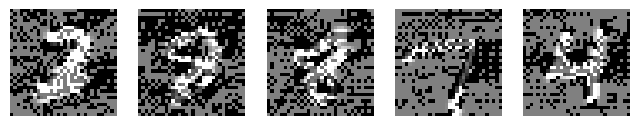

In [5]:
import random, matplotlib.pyplot as plt

# fgsm attack
def fgsm(model, images, labels, eps):
    """
    model: the trained neural network.

    images: a batch of MNIST images.

    labels: the correct labels for those images.

    eps: the attack strength.

    returns adversarial transformations
    """
    model.eval()
    images, labels = images.to(device), labels.to(device)
    images.requires_grad_(True)
    loss = criterion(model(images), labels)
    model.zero_grad(); loss.backward()
    adv = (images + eps * images.grad.sign()).clamp(0, 1)
    return adv.detach()

# FGSM ATTACK ON ZERO DEFENSE MODEL:

epsilons = [0.1, 0.2, 0.5]
model.eval()

for eps in epsilons:
    total = correct = 0
    sample_images = []

    for images, labels in test_loader:
        orig_images, orig_labels = images, labels
        adv_images = fgsm(model, images, labels, eps)

        labels = labels.to(device)
        with torch.no_grad():
            preds = model(adv_images).argmax(1)

        total += labels.size(0)
        correct += (preds==labels).sum().item()

        if len(sample_images) < 5:
            k = random.randrange(orig_images.size(0))
            sample_images.append((
                orig_images[k],
                adv_images[k].cpu(),
                orig_labels[k].item(),
                preds[k].item()
            ))

    print("epsilon =", eps, "| accuracy:", correct/total)

    plt.figure(figsize=(8,2))
    for i, (_, adv, _, _) in enumerate(sample_images):
        plt.subplot(1, 5, i+1)
        plt.imshow(adv.squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

epsilon = 0.1 | accuracy: 0.93


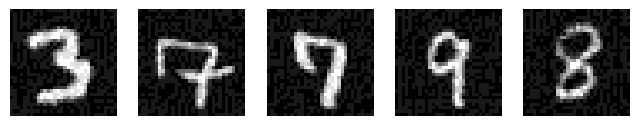

epsilon = 0.2 | accuracy: 0.9037


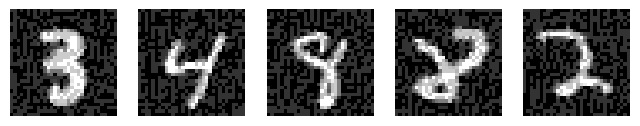

epsilon = 0.5 | accuracy: 0.0974


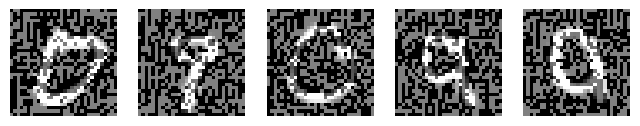

In [6]:
# FGSM DEFENSE MODEL:
fgsm_model = VGG11().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fgsm_model.parameters(), lr=0.001)

epochs = 3
for epoch in range(epochs):
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        x = fgsm(fgsm_model, x, y, eps=0.2)
        fgsm_model.train()
        optimizer.zero_grad()
        out = fgsm_model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

# FGSM ATTACK ON FGSM DEFENSE MODEL:
epsilons = [0.1, 0.2, 0.5]
fgsm_model.eval()

for eps in epsilons:
    total = correct = 0
    sample_images = []

    for images, labels in test_loader:
        orig_images, orig_labels = images, labels
        adv_images = fgsm(fgsm_model, images, labels, eps)

        labels = labels.to(device)
        with torch.no_grad():
            preds = fgsm_model(adv_images).argmax(1)

        total += labels.size(0)
        correct += (preds==labels).sum().item()

        if len(sample_images) < 5:
            k = random.randrange(orig_images.size(0))
            sample_images.append((
                orig_images[k],
                adv_images[k].cpu(),
                orig_labels[k].item(),
                preds[k].item()
            ))

    print("epsilon =", eps, "| accuracy:", correct/total)

    plt.figure(figsize=(8,2))
    for i, (_, adv, _, _) in enumerate(sample_images):
        plt.subplot(1, 5, i+1)
        plt.imshow(adv.squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

In [9]:
# pgd attack
def pgd(model, images, labels, eps, steps=7, alpha=None):
    """
    model: the trained neural network.
    images: a batch of MNIST images.
    labels: the correct labels for those images.
    eps: L-infinity attack strength.
    steps: number of PGD iterations.
    alpha: step size (defaults to eps/4).

    returns adversarial transformations
    """
    model.eval()
    images = images.to(device)
    labels = labels.to(device)
    alpha = eps/4 if alpha is None else alpha

    # random start
    adv = images.clone().detach()
    adv = adv + torch.empty_like(adv).uniform_(-eps, eps)
    adv = adv.clamp(0, 1)

    for _ in range(steps):
        adv.requires_grad_(True)
        loss = criterion(model(adv), labels)
        model.zero_grad(); loss.backward()

        # gradient ascent
        adv = adv + alpha * adv.grad.sign()

        # projection
        adv = adv.clamp(images - eps, images + eps)

        # keep pixel values valid
        adv = adv.clamp(0, 1).detach()

    return adv

In [10]:
# PGD DEFENSE MODEL:

pgd_model = VGG11().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pgd_model.parameters(), lr=0.001)

epochs = 3
for epoch in range(epochs):
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        x = pgd(pgd_model, x, y, eps=0.2, steps=7)

        pgd_model.train()
        optimizer.zero_grad()
        out = pgd_model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

epsilon = 0.1 | accuracy: 0.9519


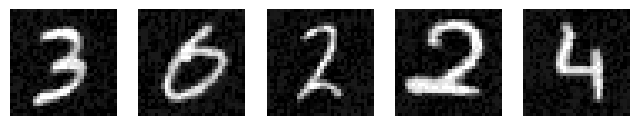

epsilon = 0.2 | accuracy: 0.8913


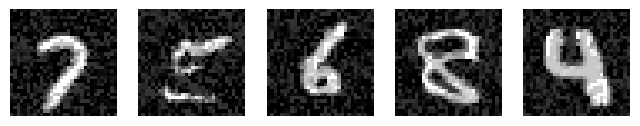

epsilon = 0.5 | accuracy: 0.0


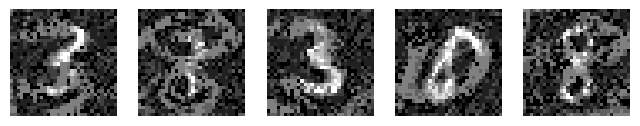

In [11]:
# PGD ATTACK ON PGD DEFENSE MODEL:

epsilons = [0.1, 0.2, 0.5]
pgd_model.eval()

for eps in epsilons:
    total = correct = 0
    sample_images = []

    for images, labels in test_loader:
        orig_images, orig_labels = images, labels
        adv_images = pgd(pgd_model, images, labels, eps=eps, steps=7)

        labels = labels.to(device)
        with torch.no_grad():
            preds = pgd_model(adv_images).argmax(1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

        if len(sample_images) < 5:
            k = random.randrange(orig_images.size(0))
            sample_images.append((
                orig_images[k],
                adv_images[k].cpu(),
                orig_labels[k].item(),
                preds[k].item()
            ))

    print("epsilon =", eps, "| accuracy:", correct / total)

    plt.figure(figsize=(8, 2))
    for i, (_, adv, _, _) in enumerate(sample_images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(adv.squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()


In [12]:
# DEFENSE COMPARISONS:

def get_acc(model, loader, attack_name, eps):
    """
    model: the nn model
    loader: loads image batches from test data
    attack_name: clean, fgsm, or pgd
    eps: attack strength

    returns model accuracy under that attack
    """
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # Apply attack if needed
        if attack_name == "fgsm":
            x = fgsm(model, x, y, eps)
        elif attack_name == "pgd":
            x = pgd(model, x, y, eps, steps=7)

        out = model(x)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct / total

# defense comparison setup
models = [model, fgsm_model, pgd_model]
attacks = ["clean", "fgsm", "pgd"]
eps = 0.3

# store outcomes in a list
results = []
for attack in attacks:
    row = []
    for m in models:
        acc = get_acc(m, test_loader, attack, eps)
        row.append(acc)
    results.append(row)

# defense/attack comparison table
print("Metric         | No Defense | FGSM Defense | PGD Defense")
print("---------------------------------------------------")
print("Standard Acc   | " + str(round(results[0][0], 3)) + "     | " + str(round(results[0][1], 3)) + "      | " + str(round(results[0][2], 3)))
print("FGSM Acc       | " + str(round(results[1][0], 3)) + "     | " + str(round(results[1][1], 3)) + "      | " + str(round(results[1][2], 3)))
print("PGD Acc        | " + str(round(results[2][0], 3)) + "     | " + str(round(results[2][1], 3)) + "      | " + str(round(results[2][2], 3)))

Metric         | No Defense | FGSM Defense | PGD Defense
---------------------------------------------------
Standard Acc   | 0.978     | 0.965      | 0.981
FGSM Acc       | 0.054     | 0.224      | 0.7
PGD Acc        | 0.0     | 0.001      | 0.25
